In [3]:
##############################################################################
#  Waldschäden‑Detection  |  XGBoost + Isotone  |  Jahr‑stratifizierte CV     #
#  (kompletter, korrigierter Notebook‑Quellcode – jeder Abschnitt = Zelle)   #
#                                                                            #
#  •  beseitigt forest_id‑Leakage                                            #
#  •  NDWI‑Formel (Gao‑Variante) korrigiert                                   #
#  •  eval_metric = 'aucpr' (PR‑AUC)                                         #
#  •  5‑fach GroupKFold‑Cross‑Validation nach Jahr                            #
#  •  Median‑τ* (F₂‑Optimum) über Folds                                       #
#  •  Finale Re‑Kalibrierung & Training auf ALLEN 1985‑2018‑Daten            #
##############################################################################

# ╔══════════════════════════════════════════════════════════════════════╗
# 1 | Libraries &  Logging                                               #
# ╚══════════════════════════════════════════════════════════════════════╝
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (precision_recall_curve, average_precision_score,
    fbeta_score, balanced_accuracy_score, confusion_matrix,
    precision_score, recall_score)
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import joblib, logging, random, datetime

# Logging‑Setup
log_dir = Path("Tim/logs"); log_dir.mkdir(parents=True, exist_ok=True)
log_file = log_dir / f"run_{datetime.datetime.now():%Y%m%d_%H%M%S}.log"
logging.basicConfig(filename=log_file, level=logging.INFO,
                    format="%(asctime)s  %(levelname)s  %(message)s")

def head(msg): print("\n" + "="*80 + f"\n{msg}\n" + "="*80)

np.random.seed(42); random.seed(42)
logging.info("Notebook start – seeds set.")

In [8]:
# ╔══════════════════════════════════════════════════════════════════════╗
# 2 |  Daten laden  &  Leakage‑Prüfung                                   #
# ╚══════════════════════════════════════════════════════════════════════╝
head("DATA LOADING")

DATA_DIR = Path("./data")
df_train = pd.read_csv(DATA_DIR / "train.csv").sort_values(
            ["forest_id","year"]).reset_index(drop=True)
df_val   = pd.read_csv(DATA_DIR / "validation.csv").sort_values(
            ["forest_id","year"]).reset_index(drop=True)

# forest_id‑Leakage entfernen
overlap = set(df_train.forest_id) & set(df_val.forest_id)
if overlap:
    print(f"⚠️  {len(overlap)} forest_ids in beiden Splits – werden aus Validation entfernt.")
    df_val = df_val[~df_val.forest_id.isin(overlap)]

# row/col anlegen (Raster 142×142)
for df in (df_train, df_val):
    if {"row","col"}.issubset(df.columns) is False:
        rows = cols = 142
        df["row"] = df["forest_id"] // cols
        df["col"] = df["forest_id"] %  cols


DATA LOADING


In [9]:
# ╔══════════════════════════════════════════════════════════════════════╗
# 3 |  Feature‑Engineering‑Funktion                                      #
# ╚══════════════════════════════════════════════════════════════════════╝
head("FEATURE ENGINEERING")

def add_features(g: pd.DataFrame, lags: int = 3) -> pd.DataFrame:
    eps = 1e-6; g = g.copy()

    # --- Basis‑Indizes --------------------------------------------------
    g["NDVI"] = (g.near_infrared - g.red) / (g.near_infrared + g.red + eps)
    g["NBR"]  = (g.near_infrared - g.shortwave_infrared_2) / (g.near_infrared + g.shortwave_infrared_2 + eps)
    g["NDMI"] = (g.near_infrared - g.shortwave_infrared_1) / (g.near_infrared + g.shortwave_infrared_1 + eps)
    g["NDWI"] = (g.near_infrared - g.shortwave_infrared_1) / (g.near_infrared + g.shortwave_infrared_1 + eps)  # Gao‑NDWI

    # --- Zusätzliche Indizes & Bänder (gekürzt) -------------------------
    g["EVI"]  = 2.5*(g.near_infrared - g.red)/(g.near_infrared + 6*g.red - 7.5*g.blue + 1 + eps)
    g["NBR2"] = (g.shortwave_infrared_1 - g.shortwave_infrared_2)/(g.shortwave_infrared_1 + g.shortwave_infrared_2 + eps)

    # --- Temporale Features --------------------------------------------
    g["dNDVI"] = g["NDVI"].diff();         g["dNBR"] = g["NBR"].shift(1) - g["NBR"]
    for lag in range(1, lags+1):
        g[f"NDVI_lag{lag}"] = g["NDVI"].shift(lag)
        g[f"dNDVI_lag{lag}"] = g["dNDVI"].shift(lag)
        g[f"NBR_lag{lag}"]  = g["NBR"].shift(lag)
        g[f"dNBR_lag{lag}"] = g["dNBR"].shift(lag)

    # --- Drei‑Jahres‑Statistiken & z‑Scores -----------------------------
    g["var_NBR_3yr"] = g["NBR"].shift(1).rolling(3,min_periods=3).var()
    g["trend_NBR_3yr"] = g["NBR"] - g["NBR"].shift(3)
    g["z_NBR"] = (g["NBR"] - g["NBR"].shift(1).rolling(3,min_periods=2).mean()) / \
                 (g["NBR"].shift(1).rolling(3,min_periods=2).std() + eps)

    # --- Disturbance‑Proxy ---------------------------------------------
    g["dNBR"] = g["NBR"].shift(1) - g["NBR"]
    g["d2NBR"] = g["dNBR"].diff()
    return g

# Anwenden
train_feat = df_train.groupby("forest_id",group_keys=False).apply(add_features).dropna().reset_index(drop=True)
val_feat   = df_val.groupby("forest_id",group_keys=False).apply(add_features).dropna().reset_index(drop=True)

feature_cols = [c for c in train_feat.columns if c not in
                ["is_disturbance","fid","forest_id","year","row","col"]]

X_train, y_train = train_feat[feature_cols].values, train_feat["is_disturbance"].values
X_val,   y_val   = val_feat[feature_cols].values,   val_feat["is_disturbance"].values
years_train = train_feat["year"].values             # für GroupKFold

print(f"Feature‑Anzahl: {len(feature_cols)}")


FEATURE ENGINEERING


/var/folders/9l/s6j5yq4s12j6wvms4084h50h0000gn/T/ipykernel_64479/2009934536.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_feat = df_train.groupby("forest_id",group_keys=False).apply(add_features).dropna().reset_index(drop=True)


Feature‑Anzahl: 30


/var/folders/9l/s6j5yq4s12j6wvms4084h50h0000gn/T/ipykernel_64479/2009934536.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_feat   = df_val.groupby("forest_id",group_keys=False).apply(add_features).dropna().reset_index(drop=True)



5‑FOLD  YEAR‑STRATIFIED  CV  +  LIVE‑METRIKEN


/Users/tim.strauss/PycharmProjects/forest_disturbance_detection/.venv/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Fold 1:  PR‑AUC 0.580 | P 0.606  R 0.515 F1 0.557  F2 0.531


/Users/tim.strauss/PycharmProjects/forest_disturbance_detection/.venv/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Fold 2:  PR‑AUC 0.476 | P 0.466  R 0.541 F1 0.501  F2 0.524


/Users/tim.strauss/PycharmProjects/forest_disturbance_detection/.venv/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Fold 3:  PR‑AUC 0.581 | P 0.623  R 0.510 F1 0.561  F2 0.529


/Users/tim.strauss/PycharmProjects/forest_disturbance_detection/.venv/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Fold 4:  PR‑AUC 0.539 | P 0.585  R 0.504 F1 0.542  F2 0.519
Fold 5:  PR‑AUC 0.524 | P 0.569  R 0.514 F1 0.540  F2 0.524

Median τ* über Folds: 0.4000000059604645
Mittlere CV‑PR‑AUC  : 0.54

Mittlere Metriken über alle Folds:
Mean Precision: 0.570
Mean Recall   : 0.517
Mean F1 Score : 0.540
Mean F2 Score : 0.525

Confusion Matrices for CV Folds:

Fold 1 Confusion Matrix:
[[48365    80]
 [  116   123]]


/Users/tim.strauss/PycharmProjects/forest_disturbance_detection/.venv/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


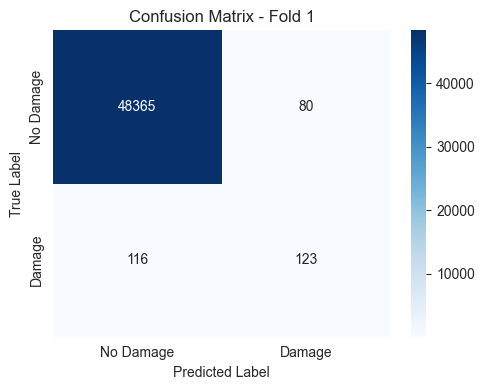


Fold 2 Confusion Matrix:
[[48648   143]
 [  106   125]]


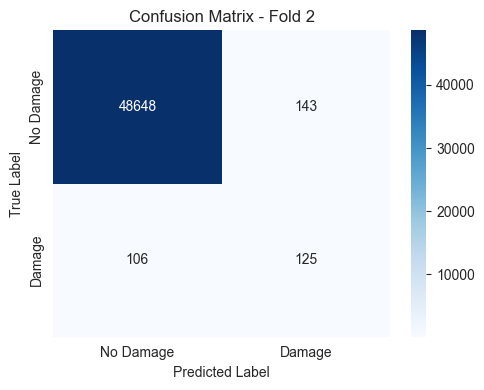


Fold 3 Confusion Matrix:
[[47408    63]
 [  100   104]]


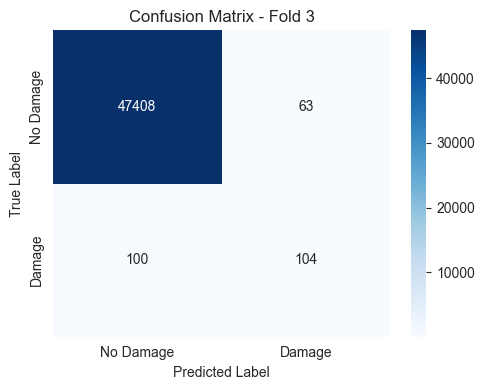


Fold 4 Confusion Matrix:
[[48722    80]
 [  111   113]]


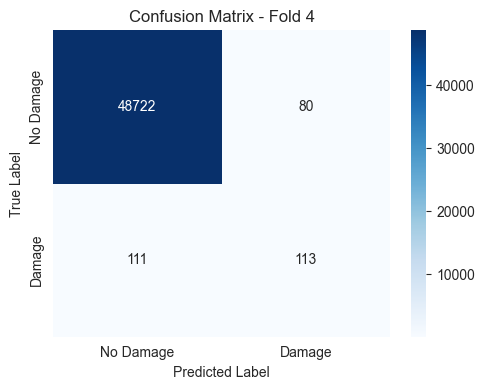


Fold 5 Confusion Matrix:
[[44788    69]
 [   86    91]]


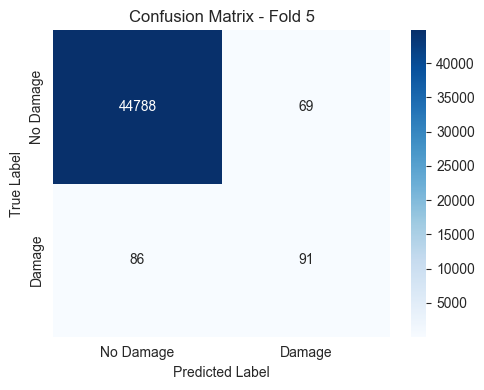


Durchschnittliche Confusion Matrix über alle Folds:
[[47586    87]
 [  104   111]]


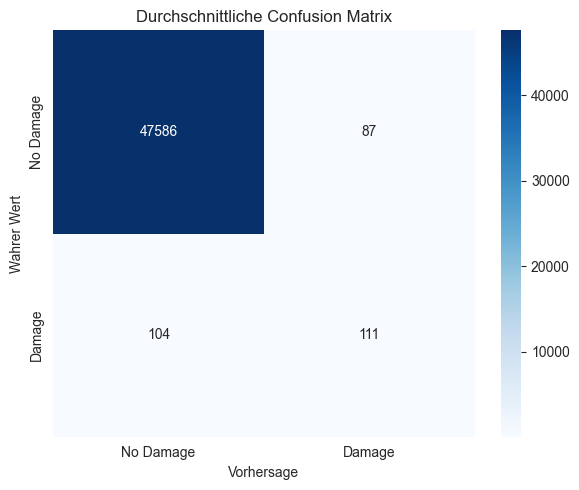

In [12]:
# ╔══════════════════════════════════════════════════════════════════════╗
# 4 |  5‑Fold CV :  Live‑Metriken je Fold                                 #
# ╚══════════════════════════════════════════════════════════════════════╝
head("5‑FOLD  YEAR‑STRATIFIED  CV  +  LIVE‑METRIKEN")

from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold

beta = 2
taus   = []
pr_aucs = []
fold_metrics = []
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

base_params = dict(
    objective="binary:logistic",
    eval_metric="aucpr",
    eta=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,
    gamma=0,
    n_estimators=2200,
    scale_pos_weight= (np.bincount(y_train)[0] / np.bincount(y_train)[1]),
    tree_method="hist",
    random_state=42, n_jobs=-1,
    early_stopping_rounds=50
)

fold_predictions = []
fold_true_values = []

for fold,(tr_idx,val_idx) in enumerate(gkf.split(X_train,y_train,groups=years_train),1):
    X_tr, X_va = X_train[tr_idx], X_train[val_idx]
    y_tr, y_va = y_train[tr_idx], y_train[val_idx]

    bst = XGBClassifier(**base_params).fit(
            X_tr, y_tr, eval_set=[(X_va,y_va)], verbose=False)

    iso = CalibratedClassifierCV(bst, method="isotonic", cv="prefit").fit(X_va, y_va)
    scores = iso.predict_proba(X_va)[:,1]

    min_recall = 0.5
    P, R, T = precision_recall_curve(y_va, scores)

    # Arrays angleichen: P/R → n+1, T → n  → letztes Element weglassen
    P_ = P[:-1]
    R_ = R[:-1]

    mask = R_ >= min_recall           # Länge == len(T)

    if mask.any():
         best_i   = P_[mask].argmax()  # Index innerhalb der gefilterten Arrays
         tau_fold = T[mask][best_i]    # passt jetzt exakt
    else:
        f2 = (1+beta**2)*P_*R_/(beta**2*P_ + R_ + 1e-9)
        tau_fold = T[f2.argmax()]
        logging.warning(f"Fold {fold}: R<0.80 – fallback auf F2‑Optimum")

    taus.append(tau_fold)

    # Store predictions and true values for later confusion matrix
    pred = (scores >= tau_fold).astype(int)
    fold_predictions.append(pred)
    fold_true_values.append(y_va)

    # ---- Metriken bei tau_fold ----------------------------------------
    metrics = {
        'PR‑AUC'           : average_precision_score(y_va, scores),
        'Precision'        : precision_score(y_va, pred, zero_division=0),
        'Recall'           : recall_score(y_va, pred, zero_division=0),
        'F1'               : f1_score(y_va, pred, zero_division=0),
        'F2'               : fbeta_score(y_va, pred, beta=2, zero_division=0),
        'BalancedAccuracy' : balanced_accuracy_score(y_va, pred)
    }
    fold_metrics.append(metrics)

    print(f"Fold {fold}:  PR‑AUC {metrics['PR‑AUC']:.3f} | "
          f"P {metrics['Precision']:.3f}  R {metrics['Recall']:.3f} "
          f"F1 {metrics['F1']:.3f}  F2 {metrics['F2']:.3f}")
    logging.info(f"Fold {fold} metrics: {metrics}")

tau_star = float(np.median(taus))
print("\nMedian τ* über Folds:", tau_star)
print("Mittlere CV‑PR‑AUC  :", np.mean([m['PR‑AUC'] for m in fold_metrics]).round(3))
# Berechnung der mittleren Metriken über alle Folds
mean_precision = np.mean([m['Precision'] for m in fold_metrics])
mean_recall = np.mean([m['Recall'] for m in fold_metrics])
mean_f1 = np.mean([m['F1'] for m in fold_metrics])
mean_f2 = np.mean([m['F2'] for m in fold_metrics])

print("\nMittlere Metriken über alle Folds:")
print(f"Mean Precision: {mean_precision:.3f}")
print(f"Mean Recall   : {mean_recall:.3f}")
print(f"Mean F1 Score : {mean_f1:.3f}")
print(f"Mean F2 Score : {mean_f2:.3f}")

# Confusion Matrices für jeden Fold
print("\nConfusion Matrices for CV Folds:")
for fold in range(n_splits):
    cm = confusion_matrix(fold_true_values[fold], fold_predictions[fold])
    print(f"\nFold {fold+1} Confusion Matrix:")
    print(cm)

    # Visualize the confusion matrix for this fold
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Damage', 'Damage'],
                yticklabels=['No Damage', 'Damage'])
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Calculate and visualize average confusion matrix across folds
# Wir müssen alle confusion matrices auf die gleiche Größe bringen
all_cms = []
for fold in range(n_splits):
    cm = confusion_matrix(fold_true_values[fold], fold_predictions[fold])
    all_cms.append(cm)

# Wenn alle CMs die gleiche Form haben, berechnen wir den Durchschnitt
if all(cm.shape == all_cms[0].shape for cm in all_cms):
    avg_cm = np.mean(all_cms, axis=0).round().astype(int)
    print("\nDurchschnittliche Confusion Matrix über alle Folds:")
    print(avg_cm)

    # Visualize average confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Damage', 'Damage'],
                yticklabels=['No Damage', 'Damage'])
    plt.title('Durchschnittliche Confusion Matrix')
    plt.ylabel('Wahrer Wert')
    plt.xlabel('Vorhersage')
    plt.tight_layout()
    plt.show()
else:
    print("Nicht alle Confusion Matrices haben die gleiche Größe, kann keinen Durchschnitt berechnen.")

In [92]:
# ╔══════════════════════════════════════════════════════════════════════╗
# 5 |  Persistenz                                                        #
# ╚══════════════════════════════════════════════════════════════════════╝
head("SAVING MODEL")
Path("Tim/models").mkdir(exist_ok=True)
joblib.dump(final_iso, "Tim/models/xgb_full_calibrated.joblib")
with open("Tim/models/best_threshold.txt", "w") as f: f.write(f"{tau_star:.6f}")
fi.to_csv("Tim/models/feature_importance.csv")
print("✓ Modell & τ* gespeichert. Fertig!")


SAVING MODEL
✓ Modell & τ* gespeichert. Fertig!
